In [118]:
import pandas as pd

df = pd.read_excel("data/nph_3069_sm_tables2.xls", sheet_name="Sheet1",
                   header=5, skipfooter=5, usecols="A:B,D:P,R:AC") \
    .fillna(0) \
    .drop(0)   \
    .rename(columns={"Unnamed: 0": "Tree", "Unnamed: 1": "Cohort"})
df = df.astype({k: int for k in df.columns[2:]})
df["Tree"] = df["Tree"].replace("a|b", "", regex=True).astype(int)
df

,Tree,Cohort,VES-01,VES-02,VES-03,VES-04,VES-05,VES-06,VES-07,VES-08,...,VIN-03,VIN-04,VIN-05,VIN-06,VIN-07,VIN-08,VIN-09,VIN-10,VIN-11,VIN-12
1,37,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,42,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,64,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,83,4,0,1,0,0,0,11,3,0,...,2,0,0,0,0,0,0,0,0,0
76,85,4,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
77,86,4,3,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib

B = nx.Graph()

# add genets nodes
B.add_nodes_from(df.columns[2:], bipartite=0)

# add tree nodes
for _, row in df.iterrows():
    B.add_node(row["Tree"], bipartite=1, cohort=row["Cohort"])

edges = []
# add edges between genets and trees
for _, row in df.iterrows():
    for genet, n in row[2:].items():
        if n > 0:
            edges.append((genet, row["Tree"]))
            
B.add_edges_from(edges)
B.remove_nodes_from([x for x in B.nodes() if B.degree(x) == 0])
B.remove_nodes_from(("VES-11", 79)) # disconnected part

Trees: 55, genets: 24


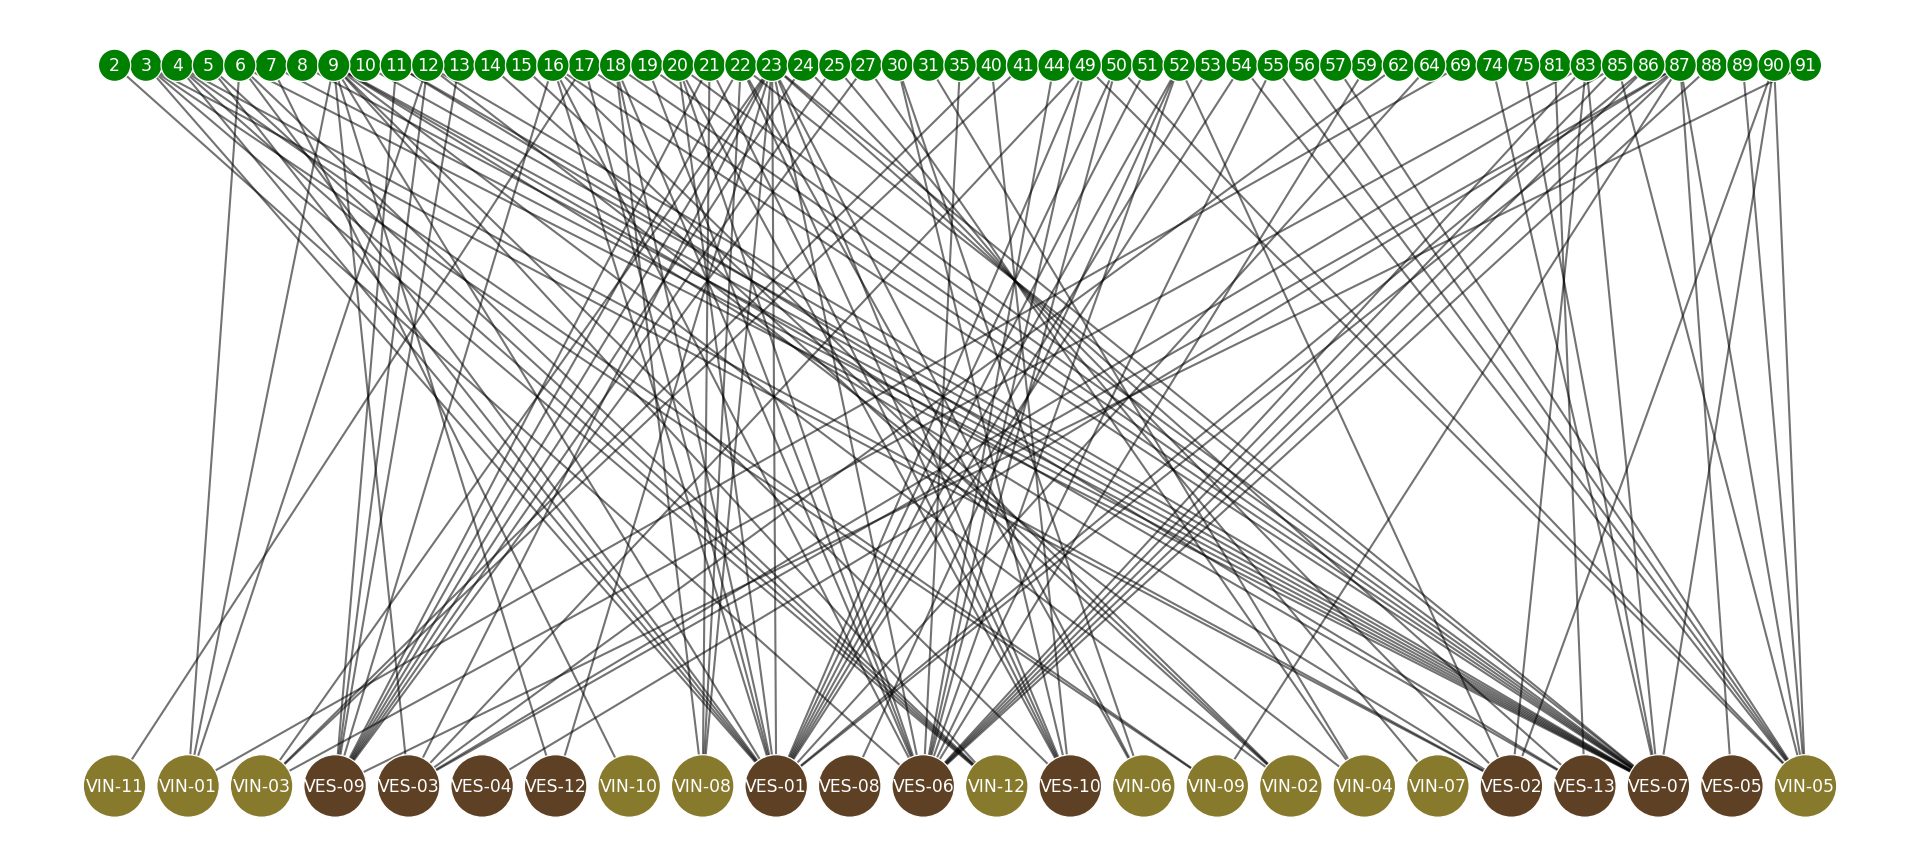

In [3]:
fungi, trees = bipartite.sets(B)
print(f"Trees: {len(trees)}, genets: {len(fungi)}")
pos = nx.bipartite_layout(B, trees, align="horizontal")

node_sizes = []
node_colors = []
for node in B.nodes:
    if B.nodes[node]["bipartite"] == 1:
        node_sizes.append(60)
        node_colors.append("green")
    else:
        node_sizes.append(225)
        if node[0:3] == "VES":
            node_colors.append("#5e4125")
        else:
            node_colors.append("#877a2d")

plt.figure(figsize=(8, 3.5), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(B, pos=pos, node_size=node_sizes, node_color=node_colors, linewidths=0.3, edgecolors="white")
nx.draw_networkx_labels(B, pos, font_color="white", font_size=4.15)
nx.draw_networkx_edges(B, pos, alpha=0.55, width=[0.5 for _ in range(len(B.nodes))])
plt.gca().set_axis_off()
plt.show()

Avg. degree: 19.490909090909092; Max degree: 47 (tree 23)


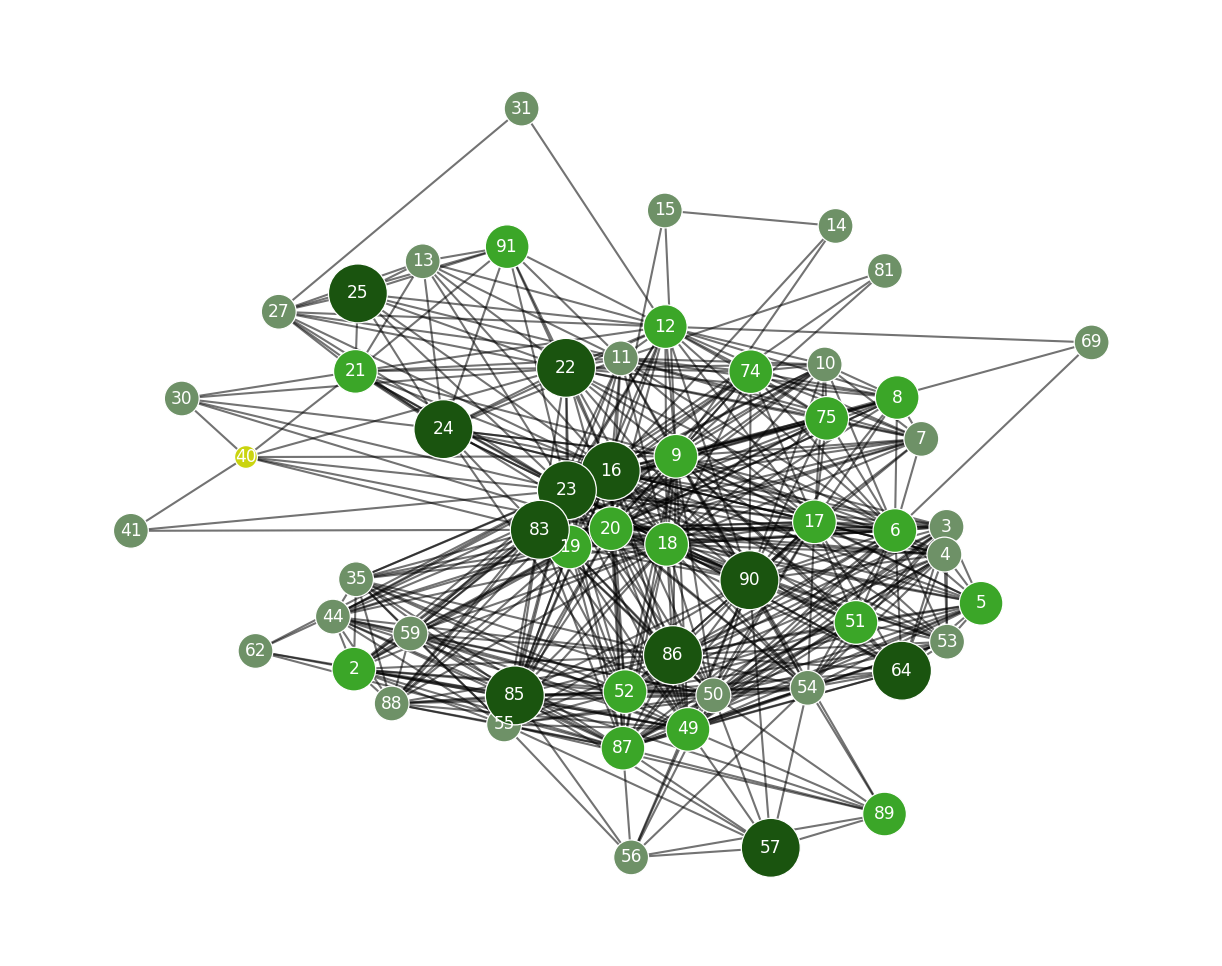

In [125]:
G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)
print(f"Avg. degree: {np.average(degrees)}; Max degree: {np.max(degrees)} (tree {sorted_degrees[-1]})")
# print(nx.get_edge_attributes(G, "weight"))

pos = nx.kamada_kawai_layout(G)#, seed=99192)

# pos[sorted_degrees[-1]] = (-1, -1)
# pos[sorted_degrees[-2]] = (0, -1)
# pos[sorted_degrees[-3]] = (1, -1)
# pos[sorted_degrees[-4]] = (1, 1)
# pos[sorted_degrees[-5]] = (0, 1)
# pos[sorted_degrees[-6]] = (-1, 1)

node_sizes = []
node_colors = []
size_values = {1:30, 2: 70, 3:110, 4:200}
color_values = {1: "#cad40f", 2: "#6e9167", 3: "#3ba628", 4:"#1a540f"}
for node in G.nodes:
    idx = G.nodes[node]["cohort"]
    node_sizes.append(size_values[idx])
    node_colors.append(color_values[idx])

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=node_colors,
                       edgecolors="white", linewidths=0.3)
nx.draw_networkx_labels(G, pos, font_color="white", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.55, width=[0.5 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

In [143]:
import graph_tool.all as gt

def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5006431ee0, at 0x7f5006439400>

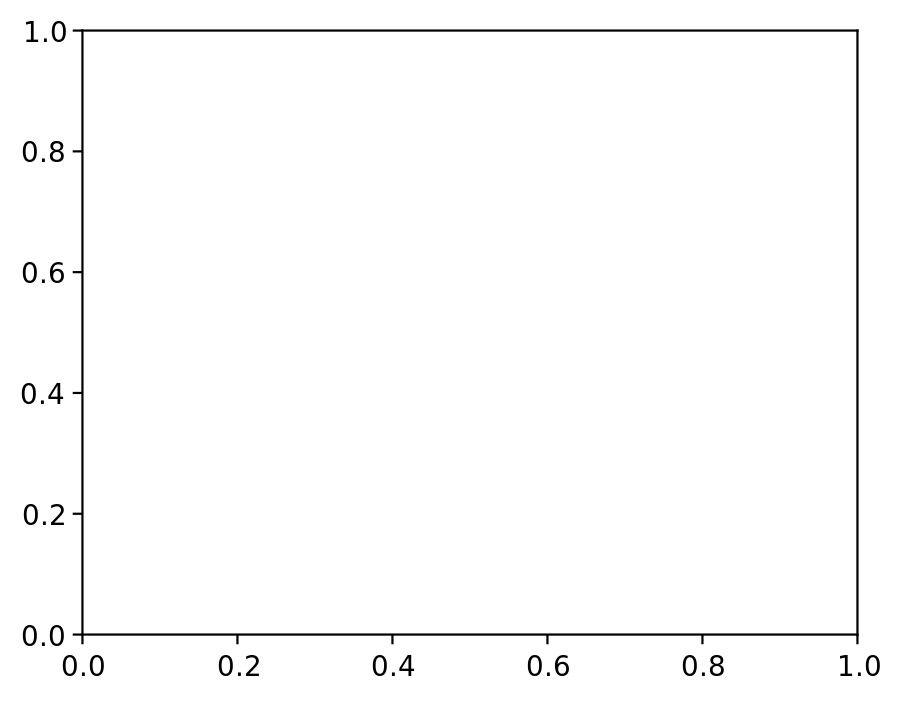

In [188]:
gtG = nx2gt(G)
cohorts = gtG.vertex_properties["cohort"]
pos = gt.fruchterman_reingold_layout(gtG, n_iter=10000)

plt.switch_backend("cairo")

fig, ax = plt.subplots(1, figsize=(5, 4), dpi=200)

gt.graph_draw(gtG, pos, vertex_text=gtG.vertex_properties["id"],
              edge_pen_width=0.5, vertex_fill_color=cohorts,
              vcmap=matplotlib.cm.YlGn, output="tree_network.pdf")

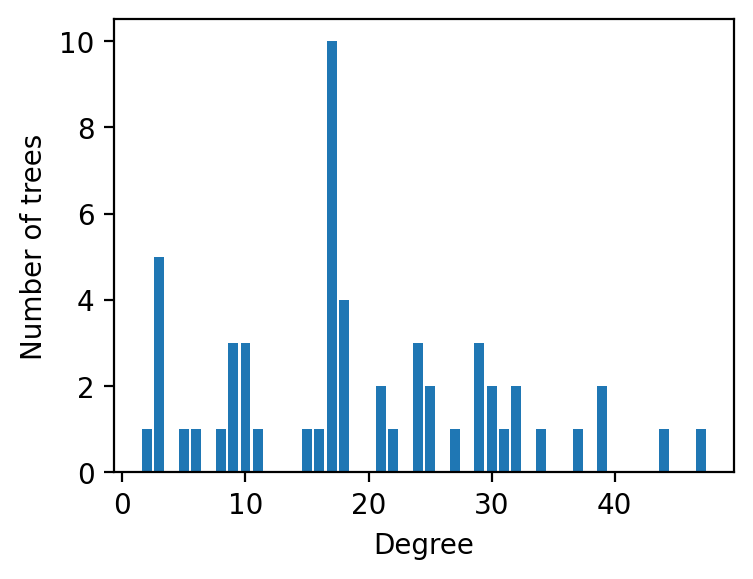

In [114]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.add_subplot()
ax.bar(*np.unique(sorted(degrees, reverse=True), return_counts=True))
ax.set_xlabel("Degree")
ax.set_ylabel("Number of trees")
plt.show()